In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
import copy
import os
import time


readable_labels = {
     0  : "day",
     1  : "season",
     2  : "year",
     3  : "month",
     4  : "hour",

     5  : "holiday",
     6  : "day of week",
     7  : "workday",

     8  : "weather",
     9  : "temperature",
     10 : "feels_like_temp",
     11 : "humidity",
     12 : "wind speed",
}


%load_ext autoreload
%autoreload 2

NEED TO DOWNLOAD BIKE SHARING DATASET FROM

https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

AND EXTRACT "hour.csv" INTO THE "data/" FOLDER

In [2]:
from data_loader import preprocess_bike_sharing_dataset
preprocess_bike_sharing_dataset()

--- processed and saved ---


## Training vanilla MLP

In [3]:
from models import *
from data_loader import loadDataset


#batch size, epochs, learning rate
BS = 32
EP = 300
LR = 5e-3

data_path = 'data/'
trnX1,trnY1,    tstX,tstY = loadDataset(data_path)

#whitening the input and output data
trnX1 = trnX1 - np.expand_dims(np.mean(trnX1,axis=0),axis=0)
trnX1 = trnX1 / np.expand_dims(np.sqrt(np.mean(trnX1**2,axis=0)),axis=0)
trnX1_og = trnX1    
trnY1_og = trnY1[:,None]-4.42

device = torch.device("cuda:0")
device = torch.device("cpu")


if True:
    mn=0
    M_NUM = trnX1_og.shape[0]
    rand_indices = np.random.permutation(M_NUM)
    per = .7
    M_TRN_NUM = int(M_NUM*per)
    trnX1 = trnX1_og[rand_indices[:M_TRN_NUM]]
    trnY1 = trnY1_og[rand_indices[:M_TRN_NUM]]
    valX1 = trnX1_og[rand_indices[M_TRN_NUM:]]
    valY1 = trnY1_og[rand_indices[M_TRN_NUM:]]


    trn_data1 = TensorDataset(torch.from_numpy(trnX1).float().to(device),
                              torch.from_numpy(trnY1).float().to(device))
    trn_loader1 =DataLoader(dataset=trn_data1, batch_size=BS,shuffle=True)

    trn_tensor = torch.from_numpy(trnX1).float().to(device)
    val_tensor = torch.from_numpy(valX1).float().to(device)


    sizes = [13,256,128,64,1]
    net1 = MLP(sizes).to(device)
    opt1 = optim.Adagrad(net1.parameters(), lr = LR)
    
    
    
    all_trn_accs = np.zeros(EP)
    all_val_accs = np.zeros(EP)
    all_losses = np.zeros((EP,len(trn_loader1),7))
    all_trn_losses = np.zeros((EP,len(trn_loader1)))
    all_val_losses = np.zeros(EP)

    best_val_score = -100
    best_net = None

    full_training_start_time = time.time()
    for k in range(EP):
        print('Epoch',k)
        start_time = time.time()

        
        #---TRAINING PHASE---
        for j,(x_batch,y_batch) in enumerate(trn_loader1):
            net1.train()
            logits = net1(x_batch)
            dnn_logits,gam_logits,shape_loss = net1(x_batch)
            logits = dnn_logits + gam_logits
            

            l1_reg = torch.zeros(1).to(device)
            all_linear_params = net1.collectParameters()
            lambda1 = 5e-5 
            l1_reg = lambda1 * torch.norm(all_linear_params, 1)


            mseloss = (y_batch.narrow(1,0,1) - logits.narrow(1,0,1))**2
            mseloss = torch.mean(mseloss)
            mseloss = mseloss
            
            
            all_trn_losses[k,j] = mseloss.item()
            loss = mseloss + l1_reg
            loss.backward()
            all_losses[k,j,0] = loss.item()
            all_losses[k,j,1] = mseloss.item()
            all_losses[k,j,2] = l1_reg.item()
            
            
            opt1.step()
            opt1.zero_grad()
        print('mean training loss\t',np.mean(all_losses[k,:,0]))
        
        
        #---VALIDATION PHASE---
        print('epoch',k,'\'')
        net1.eval()
        #training accuracy
        logits = net1(trn_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_trn_accs[k] = np.mean(((trnY1[:,0])-logits)**2)
        #validation accuracy
        logits = net1(val_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_val_accs[k] = np.mean(((valY1[:,0])-logits)**2)
        all_val_losses[k] = np.mean(((valY1[:,0])-logits)**2)
        print('MSE for train and val\t',all_trn_accs[k],'\t',all_val_accs[k])


        
        if k%1==0:
            val_score = -all_val_accs[k]
            if val_score > best_val_score:
                best_val_score = val_score
                best_net = copy.deepcopy(net1)

        end_time = time.time()
        print("--- %s seconds in epoch ---" % round((end_time - start_time),3))
        print()
    print('FULLY TRAINED USING',time.time()-full_training_start_time,'seconds')
    print()
    

Epoch 0
mean training loss	 0.897428768189227
epoch 0 '
MSE for train and val	 0.7365915393118533 	 0.7235485812341984
--- 0.778 seconds in epoch ---

Epoch 1
mean training loss	 0.6566467764924784
epoch 1 '
MSE for train and val	 0.5696789414474533 	 0.5770612433472739
--- 0.769 seconds in epoch ---

Epoch 2
mean training loss	 0.5386885991839112
epoch 2 '
MSE for train and val	 0.44142414515113737 	 0.4460589352257736
--- 0.788 seconds in epoch ---

Epoch 3
mean training loss	 0.45154831971301407
epoch 3 '
MSE for train and val	 0.31981868112414885 	 0.3329066028809113
--- 0.779 seconds in epoch ---

Epoch 4
mean training loss	 0.3912725919094242
epoch 4 '
MSE for train and val	 0.39339553807375865 	 0.41255914089225937
--- 0.773 seconds in epoch ---

Epoch 5
mean training loss	 0.3476081473416969
epoch 5 '
MSE for train and val	 0.2517777222402544 	 0.27014757138281303
--- 0.775 seconds in epoch ---

Epoch 6
mean training loss	 0.31976566910743714
epoch 6 '
MSE for train and val	 0.

mean training loss	 0.16812098903245612
epoch 53 '
MSE for train and val	 0.0800139434861647 	 0.11573793903160864
--- 0.749 seconds in epoch ---

Epoch 54
mean training loss	 0.16722080688007543
epoch 54 '
MSE for train and val	 0.08004345854801767 	 0.11597826895100924
--- 0.779 seconds in epoch ---

Epoch 55
mean training loss	 0.16625496180819682
epoch 55 '
MSE for train and val	 0.07846537460214709 	 0.11465914339011635
--- 0.805 seconds in epoch ---

Epoch 56
mean training loss	 0.16772522816403967
epoch 56 '
MSE for train and val	 0.09587264825947904 	 0.13181266935649952
--- 0.774 seconds in epoch ---

Epoch 57
mean training loss	 0.1655157626163764
epoch 57 '
MSE for train and val	 0.07738433740919982 	 0.1140688035151071
--- 0.778 seconds in epoch ---

Epoch 58
mean training loss	 0.164684074897258
epoch 58 '
MSE for train and val	 0.07731140062129523 	 0.11402242469960555
--- 0.746 seconds in epoch ---

Epoch 59
mean training loss	 0.16452297338696778
epoch 59 '
MSE for trai

mean training loss	 0.14862106904143194
epoch 106 '
MSE for train and val	 0.06600350279606888 	 0.10692444117605923
--- 0.801 seconds in epoch ---

Epoch 107
mean training loss	 0.14844263144692438
epoch 107 '
MSE for train and val	 0.06662860748174969 	 0.10628894283990083
--- 0.749 seconds in epoch ---

Epoch 108
mean training loss	 0.14845687346380265
epoch 108 '
MSE for train and val	 0.06732149922044584 	 0.10810437063835666
--- 0.801 seconds in epoch ---

Epoch 109
mean training loss	 0.14813384811897748
epoch 109 '
MSE for train and val	 0.06952298449945393 	 0.1103924907237416
--- 0.766 seconds in epoch ---

Epoch 110
mean training loss	 0.1477981105202534
epoch 110 '
MSE for train and val	 0.0680225590475049 	 0.10851621102699217
--- 0.798 seconds in epoch ---

Epoch 111
mean training loss	 0.14757597900804925
epoch 111 '
MSE for train and val	 0.06808341479739387 	 0.10885694912957926
--- 0.773 seconds in epoch ---

Epoch 112
mean training loss	 0.14741087709782552
epoch 112

mean training loss	 0.13921838151138338
epoch 158 '
MSE for train and val	 0.06562664923726114 	 0.109405187987065
--- 0.804 seconds in epoch ---

Epoch 159
mean training loss	 0.13903097742405093
epoch 159 '
MSE for train and val	 0.06123542930633144 	 0.10460290090384468
--- 0.778 seconds in epoch ---

Epoch 160
mean training loss	 0.13896128979862712
epoch 160 '
MSE for train and val	 0.06168516656005961 	 0.10450801479771986
--- 0.762 seconds in epoch ---

Epoch 161
mean training loss	 0.13889854594332274
epoch 161 '
MSE for train and val	 0.060368156175763354 	 0.1030504281539425
--- 0.788 seconds in epoch ---

Epoch 162
mean training loss	 0.1384786671546639
epoch 162 '
MSE for train and val	 0.0598877636306508 	 0.10250265929644559
--- 0.779 seconds in epoch ---

Epoch 163
mean training loss	 0.1383821721448273
epoch 163 '
MSE for train and val	 0.05988098525300393 	 0.10305144648558327
--- 0.76 seconds in epoch ---

Epoch 164
mean training loss	 0.13819487121750096
epoch 164 '


mean training loss	 0.13259520516043805
epoch 210 '
MSE for train and val	 0.055177495212888554 	 0.09990244734832217
--- 0.822 seconds in epoch ---

Epoch 211
mean training loss	 0.13250397536598268
epoch 211 '
MSE for train and val	 0.055397827535505595 	 0.100067992394752
--- 0.793 seconds in epoch ---

Epoch 212
mean training loss	 0.13248725069350883
epoch 212 '
MSE for train and val	 0.05617546645405105 	 0.10040217183826898
--- 0.811 seconds in epoch ---

Epoch 213
mean training loss	 0.1322903780175037
epoch 213 '
MSE for train and val	 0.05594135274512708 	 0.10082197521019046
--- 0.792 seconds in epoch ---

Epoch 214
mean training loss	 0.13236528517769985
epoch 214 '
MSE for train and val	 0.05516333418745923 	 0.09950661250528668
--- 0.788 seconds in epoch ---

Epoch 215
mean training loss	 0.13225418671232755
epoch 215 '
MSE for train and val	 0.059693498614713326 	 0.10449491755689014
--- 0.744 seconds in epoch ---

Epoch 216
mean training loss	 0.13211516347087798
epoch 

mean training loss	 0.127575284975474
epoch 262 '
MSE for train and val	 0.05297095990655569 	 0.09942729451960666
--- 0.77 seconds in epoch ---

Epoch 263
mean training loss	 0.12791040849978808
epoch 263 '
MSE for train and val	 0.05739934483348779 	 0.10311229321115563
--- 0.772 seconds in epoch ---

Epoch 264
mean training loss	 0.12775409844566565
epoch 264 '
MSE for train and val	 0.053367373141423605 	 0.09931782567448343
--- 0.767 seconds in epoch ---

Epoch 265
mean training loss	 0.12779904860453528
epoch 265 '
MSE for train and val	 0.05259719598289639 	 0.09846403955168775
--- 0.793 seconds in epoch ---

Epoch 266
mean training loss	 0.1274500885947806
epoch 266 '
MSE for train and val	 0.05268544523211108 	 0.09877760422846696
--- 0.771 seconds in epoch ---

Epoch 267
mean training loss	 0.12717183254292755
epoch 267 '
MSE for train and val	 0.05215953608699484 	 0.09854021496765777
--- 0.82 seconds in epoch ---

Epoch 268
mean training loss	 0.127455557736217
epoch 268 '


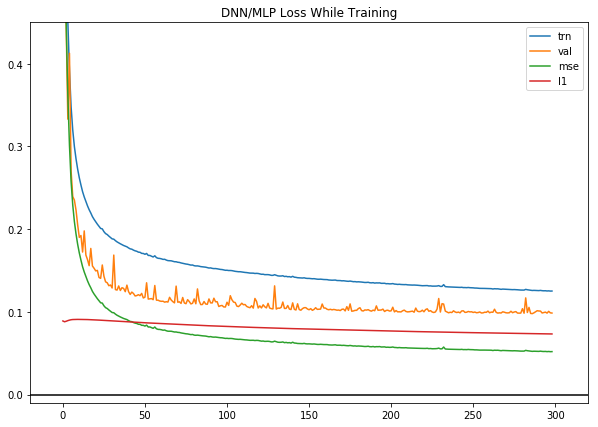

In [4]:
plt.figure(figsize=(10,7))
plt.plot(np.mean(all_losses[:k,:,0],axis=1))
plt.plot(all_val_losses[:k])
plt.plot(np.mean(all_losses[:k,:,1],axis=1))
plt.plot(np.mean(all_losses[:k,:,2],axis=1))
plt.plot([-50,EP+50],[0,0],c='k')
plt.legend(['trn','val','mse','l1'])
plt.xlim(-20,EP+20)
plt.ylim(-.01,.45)
plt.title("DNN/MLP Loss While Training")
plt.show()

## Finding Feature Interactions

In [5]:
from basic_wrappers import MixedModelWrapperTorch
device=torch.device("cpu")

model_wrap_MLP = MixedModelWrapperTorch(net1, device)

In [6]:
from aggregate_detections import aggregateContrastiveDetections_only1D, aggregateContrastiveDetections_only2D
from notebook_utils import prettyPrintInteractionSingles,prettyPrintInteractionPairs

finding and plotting the one-dimensional interaction/ main effects

In [7]:
AGG_K=100
agg_1,mains_1,grads_1,_ = aggregateContrastiveDetections_only1D(model_wrap_MLP,valX1,AGG_K)

	 0
	 10
	 20
	 30
	 40
	 50
	 60
	 70
	 80
	 90


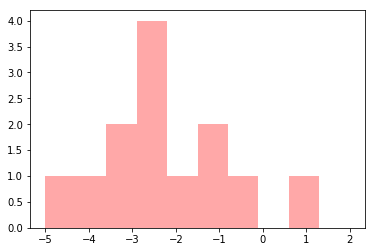

In [8]:
bins = np.linspace(-5,2,11)
plt.hist(np.log(list(agg_1.values())),color='r',alpha=.34,bins=bins)
plt.show()

In [9]:
prettyPrintInteractionSingles(agg_1,readable_labels)

Top Accumulated 1D Interactions
-------------------------------
4
hour           ;
		 2.5156340482447965

7
workday        ;
		 0.887338962339528

2
year           ;
		 0.3440553390375723

5
holiday        ;
		 0.3191499120176296

9
temperature    ;
		 0.156226054882083

1
season         ;
		 0.08843247676323514

3
month          ;
		 0.0873274609826552

8
weather        ;
		 0.08622823881557257

10
feels_like_temp;
		 0.07178829825908106

11
humidity       ;
		 0.05293079293844226

6
day of week    ;
		 0.05181468724190819

0
day            ;
		 0.026508921983901892

12
wind speed     ;
		 0.013186776572698983



finding and plotting the two-dimensional interaction effects

In [10]:
AGG_K=100
agg_2,mains_2,grads_2,_ = aggregateContrastiveDetections_only2D(model_wrap_MLP,valX1,AGG_K)

	 0
	 10
	 20
	 30
	 40
	 50
	 60
	 70
	 80
	 90


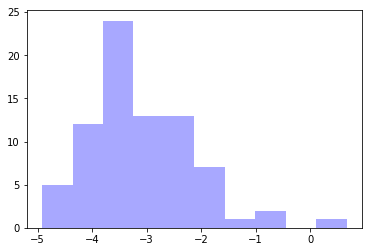

In [11]:
bins = np.linspace(-5,2,11)
plt.hist(np.log(list(agg_2.values())),color='b',alpha=.34)
plt.show()

In [12]:
prettyPrintInteractionPairs(agg_2,readable_labels)

Top Accumulated 2D Interactions
-------------------------------
4 7
hour           ; workday        
		 1.945275395337919

5 7
holiday        ; workday        
		 0.5558336827641437

4 5
hour           ; holiday        
		 0.5423296005838537

5 10
holiday        ; feels_like_temp
		 0.24234767812449087

4 9
hour           ; temperature    
		 0.17469543548392852

1 5
season         ; holiday        
		 0.15737598639769057

5 9
holiday        ; temperature    
		 0.15314240233984902

2 5
year           ; holiday        
		 0.13754884400370845

1 4
season         ; hour           
		 0.13543182744155494

1 3
season         ; month          
		 0.12814374220675395

1 7
season         ; workday        
		 0.12351030913833894

0 5
day            ; holiday        
		 0.11142789944647997

2 7
year           ; workday        
		 0.10767525034551763

6 7
day of week    ; workday        
		 0.10290141269784533

4 10
hour           ; feels_like_temp
		 0.10264169289310417

3 7
month          ; wo

## Training a SIAN-2 Generalized Additive Model

feel free to exchange these indices for a different set
and explore the effects of changing the available interactions

can compare to the families of indices used in Figure 2 of the paper

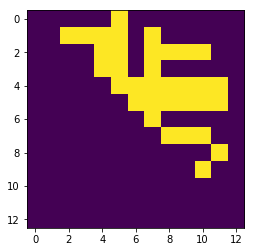

In [13]:
indices1 = [(i,) for i in range(13)]
indices2 = [(4, 7), (5, 7), (4, 5), (2, 5), (4, 10), (5, 8), (5, 10), (4, 9), (6, 7), (1, 3), (5, 9), (2, 4), (1, 7), (7, 10), (2, 7), (1, 4), (7, 9), (4, 6), (3, 7), (1, 5), (3, 4), (1, 2), (5, 6), (4, 8), (4, 11), (9, 10), (5, 11), (7, 8), (3, 5), (0, 5), (2, 10), (2, 8), (8, 11), (2, 9)]

indices = []
indices.extend(indices1)
indices.extend(indices2)

D = 13
interactions_matrix = np.zeros((D,D),dtype=int)
for (i,j) in indices2:
    interactions_matrix[i,j] = 1
plt.imshow(interactions_matrix) #plot of the interactions we are using
plt.show()

In [14]:
from models import *
from data_loader import loadDataset



#batch size, epochs, learning rate
BS = 32
EP = 300
LR = 5e-3

data_path = 'data/'
trnX1,trnY1,    tstX,tstY = loadDataset(data_path)

#whitening the input and output data
trnX1 = trnX1 - np.expand_dims(np.mean(trnX1,axis=0),axis=0)
trnX1 = trnX1 / np.expand_dims(np.sqrt(np.mean(trnX1**2,axis=0)),axis=0)
trnX1_og = trnX1    
trnY1_og = trnY1[:,None]-4.42

device = torch.device("cuda:0")
#device = torch.device("cpu")


#for mn in range(5):
if True:
    mn=0
    M_NUM = trnX1_og.shape[0]
    rand_indices = np.random.permutation(M_NUM)
    per = .7
    M_TRN_NUM = int(M_NUM*per)
    trnX1 = trnX1_og[rand_indices[:M_TRN_NUM]]
    trnY1 = trnY1_og[rand_indices[:M_TRN_NUM]]
    valX1 = trnX1_og[rand_indices[M_TRN_NUM:]]
    valY1 = trnY1_og[rand_indices[M_TRN_NUM:]]


    trn_data1 = TensorDataset(torch.from_numpy(trnX1).float().to(device),
                              torch.from_numpy(trnY1).float().to(device))
    trn_loader1 =DataLoader(dataset=trn_data1, batch_size=BS,shuffle=True)

    trn_tensor = torch.from_numpy(trnX1).float().to(device)
    val_tensor = torch.from_numpy(valX1).float().to(device)


    sizes = [13,256,128,64,1]
    sian_net1 = SIAN(sizes,indices,False).to(device)
    
    opt1 = optim.Adagrad(sian_net1.parameters(), lr = LR)
    
    
    all_trn_accs = np.zeros(EP)
    all_val_accs = np.zeros(EP)
    all_losses = np.zeros((EP,len(trn_loader1),7))
    all_trn_losses = np.zeros((EP,len(trn_loader1)))
    all_val_losses = np.zeros(EP)

    best_val_score = -100
    best_net2 = None

    full_training_start_time = time.time()
    for k in range(EP):
        print('Epoch',k)
        start_time = time.time()

        
        #---TRAINING PHASE---
        for j,(x_batch,y_batch) in enumerate(trn_loader1):
            sian_net1.train()
            logits = sian_net1(x_batch)
            dnn_logits,gam_logits,shape_loss = sian_net1(x_batch)
            logits = dnn_logits + gam_logits
            

            l1_reg = torch.zeros(1).to(device)
            all_linear_params = sian_net1.collectParameters()
            lambda1 = 5e-5 
            l1_reg = lambda1 * torch.norm(all_linear_params, 1)


            mseloss = (y_batch.narrow(1,0,1) - logits.narrow(1,0,1))**2
            mseloss = torch.mean(mseloss)
            mseloss = mseloss
            
            
            all_trn_losses[k,j] = mseloss.item()
            loss = mseloss + l1_reg
            loss.backward()
            all_losses[k,j,0] = loss.item()
            all_losses[k,j,1] = mseloss.item()
            all_losses[k,j,2] = l1_reg.item()
            
            
            opt1.step()
            opt1.zero_grad()
        print('mean training loss\t',np.mean(all_losses[k,:,0]))
        
        
        #---VALIDATION PHASE---
        print('epoch',k,'\'')
        sian_net1.eval()
        #training accuracy
        logits = sian_net1(trn_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_trn_accs[k] = np.mean(((trnY1[:,0])-logits)**2)
        #validation accuracy
        logits = sian_net1(val_tensor)
        logits = logits[0]+logits[1]
        logits = logits.cpu().detach().numpy()[:,0]
        all_val_accs[k] = np.mean(((valY1[:,0])-logits)**2)
        all_val_losses[k] = np.mean(((valY1[:,0])-logits)**2)
        print('MSE for train and val\t',all_trn_accs[k],'\t',all_val_accs[k])


        
        if k%1==0:
            val_score = -all_val_accs[k]
            if val_score > best_val_score:
                best_val_score = val_score
                best_net2 = copy.deepcopy(sian_net1)

        end_time = time.time()
        print("--- %s seconds in epoch ---" % round((end_time - start_time),3))
        print()
    print('FULLY TRAINED USING',time.time()-full_training_start_time,'seconds')
    print()
    

Epoch 0
mean training loss	 0.9097197927412439
epoch 0 '
MSE for train and val	 0.6333648132508798 	 0.6609520101870089
--- 1.104 seconds in epoch ---

Epoch 1
mean training loss	 0.6626342992313573
epoch 1 '
MSE for train and val	 0.563695331319396 	 0.5889457804980325
--- 0.946 seconds in epoch ---

Epoch 2
mean training loss	 0.606735283722643
epoch 2 '
MSE for train and val	 0.5224143508674159 	 0.5455284062091751
--- 0.954 seconds in epoch ---

Epoch 3
mean training loss	 0.5694085488553907
epoch 3 '
MSE for train and val	 0.4833471425109601 	 0.505215202284749
--- 0.947 seconds in epoch ---

Epoch 4
mean training loss	 0.5364052508698135
epoch 4 '
MSE for train and val	 0.4560580922385569 	 0.4766894911388825
--- 0.95 seconds in epoch ---

Epoch 5
mean training loss	 0.5026875336639217
epoch 5 '
MSE for train and val	 0.4181899270139506 	 0.4381737129330505
--- 0.949 seconds in epoch ---

Epoch 6
mean training loss	 0.47223335651100656
epoch 6 '
MSE for train and val	 0.402322739

mean training loss	 0.1861136058314902
epoch 53 '
MSE for train and val	 0.12410115321465895 	 0.1340218027492496
--- 0.96 seconds in epoch ---

Epoch 54
mean training loss	 0.18552955750559197
epoch 54 '
MSE for train and val	 0.12380124120391753 	 0.13355355272583838
--- 0.962 seconds in epoch ---

Epoch 55
mean training loss	 0.1851053747730177
epoch 55 '
MSE for train and val	 0.12396694451408544 	 0.13365708849924535
--- 0.957 seconds in epoch ---

Epoch 56
mean training loss	 0.18481028541678288
epoch 56 '
MSE for train and val	 0.12559793402238853 	 0.1355677580974852
--- 0.962 seconds in epoch ---

Epoch 57
mean training loss	 0.18405240869424383
epoch 57 '
MSE for train and val	 0.12297125679593346 	 0.13272023221745946
--- 0.959 seconds in epoch ---

Epoch 58
mean training loss	 0.184166545775093
epoch 58 '
MSE for train and val	 0.12265002575085573 	 0.13259021803772322
--- 0.961 seconds in epoch ---

Epoch 59
mean training loss	 0.18331680178153711
epoch 59 '
MSE for train 

mean training loss	 0.17244941963524116
epoch 106 '
MSE for train and val	 0.11523630572809913 	 0.1256280238496645
--- 0.965 seconds in epoch ---

Epoch 107
mean training loss	 0.17225870192050935
epoch 107 '
MSE for train and val	 0.11511905353846637 	 0.12563588645849993
--- 0.965 seconds in epoch ---

Epoch 108
mean training loss	 0.17218747383258382
epoch 108 '
MSE for train and val	 0.11506946238063877 	 0.12548134476061767
--- 0.963 seconds in epoch ---

Epoch 109
mean training loss	 0.17185345915008765
epoch 109 '
MSE for train and val	 0.11500105878737714 	 0.12537086694205776
--- 0.964 seconds in epoch ---

Epoch 110
mean training loss	 0.17201564614890053
epoch 110 '
MSE for train and val	 0.11502888851856248 	 0.1254118962377931
--- 0.962 seconds in epoch ---

Epoch 111
mean training loss	 0.17196653578125062
epoch 111 '
MSE for train and val	 0.11506061201367952 	 0.12559751507423877
--- 0.962 seconds in epoch ---

Epoch 112
mean training loss	 0.17164295127645868
epoch 11

mean training loss	 0.1667674321864472
epoch 158 '
MSE for train and val	 0.11379602808457885 	 0.12408118561415381
--- 0.962 seconds in epoch ---

Epoch 159
mean training loss	 0.16617876613726382
epoch 159 '
MSE for train and val	 0.11199979765769877 	 0.12281776115473127
--- 0.962 seconds in epoch ---

Epoch 160
mean training loss	 0.1657330925347375
epoch 160 '
MSE for train and val	 0.11170807758893574 	 0.12240788577913739
--- 0.968 seconds in epoch ---

Epoch 161
mean training loss	 0.16615490190318374
epoch 161 '
MSE for train and val	 0.11192822534612845 	 0.12273408565754987
--- 0.994 seconds in epoch ---

Epoch 162
mean training loss	 0.16599790207186682
epoch 162 '
MSE for train and val	 0.11206700657285466 	 0.12292008206702715
--- 0.987 seconds in epoch ---

Epoch 163
mean training loss	 0.16636364689615907
epoch 163 '
MSE for train and val	 0.11218163833869559 	 0.12270592646473606
--- 0.973 seconds in epoch ---

Epoch 164
mean training loss	 0.1657975800457548
epoch 164

mean training loss	 0.16238690118809215
epoch 210 '
MSE for train and val	 0.1098155478379149 	 0.1205753683234123
--- 0.97 seconds in epoch ---

Epoch 211
mean training loss	 0.16256543498058787
epoch 211 '
MSE for train and val	 0.11108299762409538 	 0.12220732203294386
--- 0.974 seconds in epoch ---

Epoch 212
mean training loss	 0.1622765346140158
epoch 212 '
MSE for train and val	 0.11043277079700349 	 0.1215008690481018
--- 0.963 seconds in epoch ---

Epoch 213
mean training loss	 0.16386498398468144
epoch 213 '
MSE for train and val	 0.1110572880457126 	 0.12154691063436722
--- 0.974 seconds in epoch ---

Epoch 214
mean training loss	 0.16213243747832345
epoch 214 '
MSE for train and val	 0.10995955442463984 	 0.12065640714228203
--- 0.981 seconds in epoch ---

Epoch 215
mean training loss	 0.16190862623883076
epoch 215 '
MSE for train and val	 0.10965238398196218 	 0.12043618018989695
--- 0.976 seconds in epoch ---

Epoch 216
mean training loss	 0.16193037631570315
epoch 216 '


mean training loss	 0.15917710974568225
epoch 262 '
MSE for train and val	 0.10847562339213408 	 0.11928203227126453
--- 0.981 seconds in epoch ---

Epoch 263
mean training loss	 0.1592281836466711
epoch 263 '
MSE for train and val	 0.10865415033514376 	 0.11937508764488772
--- 0.977 seconds in epoch ---

Epoch 264
mean training loss	 0.15913574153282603
epoch 264 '
MSE for train and val	 0.10870029887042267 	 0.11975690803706397
--- 0.983 seconds in epoch ---

Epoch 265
mean training loss	 0.15943097286537045
epoch 265 '
MSE for train and val	 0.10838093264794882 	 0.11931842468426453
--- 0.971 seconds in epoch ---

Epoch 266
mean training loss	 0.15902162763427516
epoch 266 '
MSE for train and val	 0.10835441272179641 	 0.11918363199978113
--- 0.973 seconds in epoch ---

Epoch 267
mean training loss	 0.15893987756772118
epoch 267 '
MSE for train and val	 0.10874172525164631 	 0.11979898753339764
--- 0.968 seconds in epoch ---

Epoch 268
mean training loss	 0.1591514881272785
epoch 26

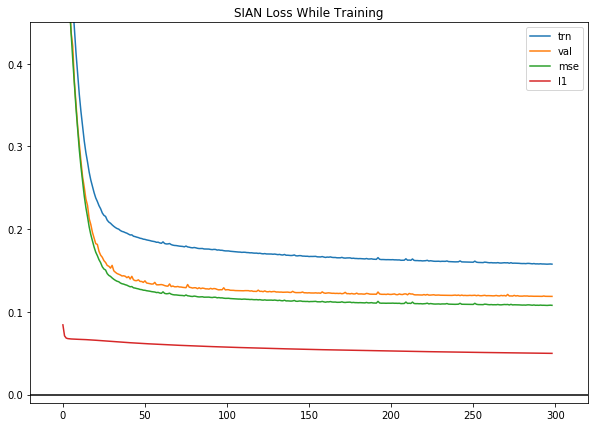

In [15]:
plt.figure(figsize=(10,7))
plt.plot(np.mean(all_losses[:k,:,0],axis=1))
plt.plot(all_val_losses[:k])
plt.plot(np.mean(all_losses[:k,:,1],axis=1))
plt.plot(np.mean(all_losses[:k,:,2],axis=1))
plt.plot([-50,EP+50],[0,0],c='k')
plt.legend(['trn','val','mse','l1'])
plt.xlim(-20,EP+20)
plt.ylim(-.01,.45)
plt.title("SIAN Loss While Training")
plt.show()